In [11]:
import numpy as np
import pandas as pd
import os
import re

from survivors.tree import CRAID
from survivors.experiments import grid as exp
from survivors import datasets as ds
from survivors.tree.stratified_model import LeafModel, LeafOnlySurviveModel, BaseFastSurviveModel, LeafOnlyHazardModel
from survivors import constants as cnt

from sksurv.linear_model import CoxPHSurvivalAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))

def load_clear_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    df['fac_type'] = str_to_categ(df['fac_type'])
    sign = ['num_temp', 'fac_type']
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

def load_capacity_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    df['fac_type'] = str_to_categ(df['fac_type'])
    categ = ['fac_type']
    sign = ['num_temp', 'fac_type', 'Capacity']
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

def load_all_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    categ = ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']
    sign = list(set(df.columns) - set(['fac_type', cnt.CENS_NAME, cnt.TIME_NAME, 'pid']))
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

In [4]:
DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "WUHAN": ds.load_wuhan_dataset,
    "PBC": ds.load_pbc_dataset,
    "HARD_1": load_clear_hdfail_dataset,
    "HARD_2": load_capacity_hdfail_dataset,
    "HARD_ALL": load_all_hdfail_dataset
}

In [5]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter

feats = ['Capacity', 'Form Factor', 'Height', 'Weight', "num_temp", "Buffer Size"]

class AFTBase(LeafModel):
    def __init__(self):
        super().__init__()
        
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        X = X_node.fillna(0).replace(np.nan, 0)
        self.model.fit(X, cnt.TIME_NAME, cnt.CENS_NAME)
        super().fit(X_node, need_features)

    def predict_survival_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        sf = self.model.predict_survival_function(X.fillna(0).replace(np.nan, 0), 
                                                  times=bins).to_numpy().T
        return sf

    def predict_hazard_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        hf = self.model.predict_cumulative_hazard(X.fillna(0).replace(np.nan, 0), 
                                                  times=bins).to_numpy().T
        return hf
    
class AFTLogLogisticAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = LogLogisticAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)
    
class AFTLogNormalAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = LogNormalAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)
        
class AFTWeibullAFTFitter(AFTBase):
    def fit(self, X_node, need_features=[cnt.TIME_NAME, cnt.CENS_NAME]):
        self.model = WeibullAFTFitter(penalizer = 0.5, l1_ratio = 0.5)
        super().fit(X_node, need_features)

In [48]:
GBSG_PARAMS = {
    "TREE": {
        "depth": [3, 5],
        "criterion": ["logrank", "peto", "tarone-ware", "wilcoxon"],
        "min_samples_leaf": [10, 100],
        'cut': [True, False],
        "signif": [0.3],
        "max_features": [1.0],
        "leaf_model": [LeafOnlySurviveModel, AFTLogLogisticAFTFitter, AFTWeibullAFTFitter]
    },
    "OnlyKM": {}
}

HARD_PARAMS = {
    "TREE_KM": {
        "depth": [5],
        "criterion": ["tarone-ware", "wilcoxon"],
        "min_samples_leaf": [1000, 3000, 5000],
        'cut': [True, False],
        "signif": [0.01],
        "max_features": [1.0],
        "leaf_model": [LeafOnlySurviveModel]
    },
    "TREE_AFT": {
        "depth": [5],
        "criterion": ["tarone-ware", "wilcoxon"],
        "min_samples_leaf": [1000, 3000, 5000],
        'cut': [True],
        "signif": [0.3],
        "max_features": [1.0],
        "leaf_model": [AFTLogLogisticAFTFitter]  # LeafOnlySurviveModel, 
    },
    "OnlyKM": {}
}

PARAMS = {
    "GBSG": GBSG_PARAMS,
    "HARD_1": HARD_PARAMS,
    "HARD_2": HARD_PARAMS,
    "HARD_ALL": HARD_PARAMS
}

In [49]:
def run(dataset="GBSG"):
    lst_metrics = ["IBS", "IAUC"]
    if not (dataset in DATASETS_LOAD):
        print("DATASET %s IS NOT DEFINED" % (dataset))
    X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
    experim = exp.Experiments(folds=5, dataset_name=dataset, except_stop="any")
    experim.set_metrics(lst_metrics)
    
    experim.add_method(LeafOnlySurviveModel, {})
    experim.add_method(AFTLogLogisticAFTFitter, {})
    experim.add_method(AFTWeibullAFTFitter, {})
    
    PARAMS[dataset]["TREE_KM"]["categ"] = [categ]
    experim.add_method(CRAID, PARAMS[dataset]["TREE_KM"])
    
    PARAMS[dataset]["TREE_AFT"]["categ"] = [categ]
    experim.add_method(CRAID, PARAMS[dataset]["TREE_AFT"])
    experim.run(X, y, verbose=1)
    df_full = experim.get_result()
    return df_full

df_result_hard = run(dataset="GBSG")

<class 'survivors.tree.decision_tree.CRAID'> {'depth': [5], 'criterion': ['tarone-ware', 'wilcoxon'], 'min_samples_leaf': [1000, 3000, 5000], 'cut': [True, False], 'signif': [0.01], 'max_features': [1.0], 'leaf_model': [<class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>], 'categ': [['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 88.33493852615356 {'IBS': 0.17844040715400414, 'IAUC': 0.5933388286257498}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 80.86776661872864 {'IBS': 0.19744109921869, 'IAUC': 0.5471530262131561}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 78.82608985900879 {'IBS': 0.1986241820463578, 'IAUC': 0.6077648854659559}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 79.48415088653564 {'IBS': 0.1771543513208679, 'IAUC': 0.6068209342680864}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 75.78640508651733 {'IBS': 0.16031549571230005, 'IAUC': 0.5976974346724854}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 75.48788905143738 {'IBS': 0.12199390775506709, 'IAUC': 0.6312592506962479}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 86.63319063186646 {'IBS': 0.24207668911484864, 'IAUC': 0.5642749656446929}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 77.9551169872284 {'IBS': 0.19146609904351314, 'IAUC': 0.5295250406493377}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 78.69618773460388 {'IBS': 0.22101528055888023, 'IAUC': 0.5647192264784537}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 78.35182523727417 {'IBS': 0.21754419971491745, 'IAUC': 0.5771259222153617}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


EXECUTION TIME OF CRAID: 75.20387864112854 {'IBS': 0.1603049139712261, 'IAUC': 0.5502574002369159}
EXECUTION TIME OF CRAID: 76.00412893295288 {'IBS': 0.20227508425918347, 'IAUC': 0.6080049975019088}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:202: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


In [10]:
df_result.to_excel("GBSG_AFT_result.xlsx", index = False)

In [21]:
df_result_hard["PARAMS"][10]

"{'categ': ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer'], 'criterion': 'tarone-ware', 'cut': False, 'depth': 5, 'leaf_model': <class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>, 'max_features': 1.0, 'min_samples_leaf': 3000, 'signif': 0.3}"

In [45]:
df_result_hard["PARAMS"][0]

"{'categ': ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer'], 'criterion': 'tarone-ware', 'cut': True, 'depth': 3, 'leaf_model': <class 'survivors.tree.stratified_model.LeafOnlySurviveModel'>, 'max_features': 1.0, 'min_samples_leaf': 500, 'signif': 0.01}"

In [136]:
X, y, features, categ, sch_nan = DATASETS_LOAD["HARD_1"]()

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_20052\2367396338.py:15: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  hard_disks = pd.read_csv("./hard_disk.csv")


(array([4.115e+03, 6.086e+03, 7.304e+03, 5.393e+03, 3.649e+03, 3.697e+03,
        4.061e+03, 4.272e+03, 1.107e+03, 1.123e+03, 1.566e+03, 1.654e+03,
        2.096e+03, 2.115e+03, 1.181e+03, 5.460e+02, 3.600e+02, 1.089e+03,
        3.210e+02, 2.780e+02, 4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

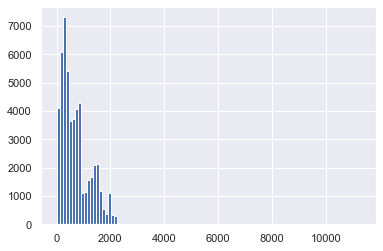

In [144]:
plt.hist(y["time"], bins = 100)

In [147]:
sorted(y["time"])[::-1]

[11295.125,
 6822.083333333333,
 5827.375,
 5745.791666666667,
 4669.916666666667,
 3602.708333333333,
 3408.6666666666665,
 3393.583333333333,
 3356.375,
 3338.2916666666665,
 3336.0,
 3272.833333333333,
 3251.458333333333,
 3220.125,
 3211.2916666666665,
 3198.2916666666665,
 3188.333333333333,
 3185.0416666666665,
 3169.333333333333,
 3117.625,
 3086.625,
 3035.25,
 2998.25,
 2977.958333333333,
 2912.0416666666665,
 2910.708333333333,
 2910.125,
 2865.1666666666665,
 2854.2916666666665,
 2845.4166666666665,
 2764.0,
 2721.2916666666665,
 2661.583333333333,
 2543.0,
 2489.625,
 2483.9166666666665,
 2431.208333333333,
 2380.083333333333,
 2369.833333333333,
 2364.083333333333,
 2338.375,
 2282.083333333333,
 2248.708333333333,
 2234.875,
 2234.7916666666665,
 2234.75,
 2234.5,
 2234.25,
 2234.25,
 2234.208333333333,
 2234.1666666666665,
 2234.125,
 2234.0,
 2233.9166666666665,
 2233.9166666666665,
 2233.875,
 2233.875,
 2233.833333333333,
 2233.833333333333,
 2233.833333333333,
 2233.

In [199]:
hard_disks[hard_disks["time"] > 10000]

,pid,cens,time,num_temp,fac_type,index,Hard Disk Model,Disk Family,Form Factor,Capacity,...,Rotational Speed,Rotation Time,Average Rotational Latency,Drive Ready Time (typical),Average Seek Time,Track To Track Seek Time,Full Stroke Seek Time,Acoustic (Idle),Acoustic (Min performance and volume),Acoustic (Max performance and volume)


In [18]:
hard_disks = pd.read_csv("./hard_disk.csv")
hard_disks = hard_disks.rename({'event': cnt.CENS_NAME, 'time': cnt.TIME_NAME}, axis=1)

ll = BaseFastSurviveModel()
ll.fit(hard_disks)

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_18968\1862964119.py:1: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  hard_disks = pd.read_csv("./hard_disk.csv")


In [20]:
bins = cnt.get_bins(hard_disks[cnt.TIME_NAME].to_numpy(), hard_disks[cnt.CENS_NAME].to_numpy())

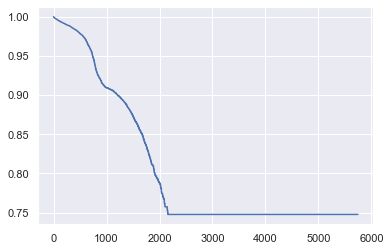

In [21]:
sf = ll.predict_survival_at_times(bins=bins)
plt.step(bins, sf)

In [190]:
cr = CRAID(depth=3, min_samples_leaf=1000, leaf_model="base_fast")
cr.fit(X, y)

In [191]:
sf = cr.predict_at_times(X, bins=bins, mode="surv")

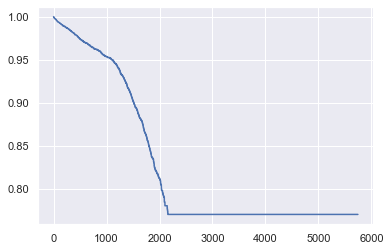

In [197]:
plt.step(bins, sf[-1])

In [198]:
y[-1]

(False, 1385.70833333)

(array([3.0262e+04, 1.3789e+04, 7.4190e+03, 5.5400e+02, 2.5000e+01,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([2.77777778e-03, 1.13726389e+01, 2.27425000e+01, 3.41123611e+01,
        4.54822222e+01, 5.68520833e+01, 6.82219444e+01, 7.95918056e+01,
        9.09616667e+01, 1.02331528e+02, 1.13701389e+02]),
 <BarContainer object of 10 artists>)

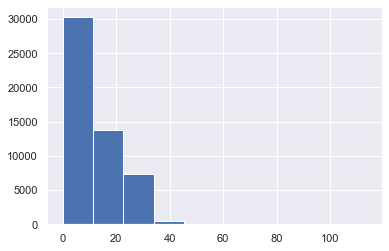

In [235]:
plt.hist(hard_disks["time"]/60)